# Problem description

The problem of interest is the prediction of apply rate. Imagine a user visiting a website, and performing a job search. From the set of displayed results, user clicks on certain ones that she is interested in, and after checking job descriptions, she further clicks on apply button therein to land in to an application page. The apply rate is defined as the fraction of applies (after visiting job description pages), and the goal is to predict this metric using the dataset described in the following section.

### Data Collection

In [22]:
# import library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
df = pd.read_csv('data/Apply_Rate_2019.csv')

In [24]:
df.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply,search_date_pacific,class_id
0,0.000000,0.000000,0.000000,0.004824,0.006628,0.0,5.0,0,2018-01-21,-7613806991329176388
1,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,0,2018-01-21,-1361819269400927213
2,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,1,2018-01-21,-1361819269400927213
3,0.000000,0.000000,3.695809,0.013046,0.033340,0.0,5.0,0,2018-01-23,-3623880078591607667
4,NaN,NaN,7.868900,0.008065,0.008772,0.0,7.0,0,2018-01-24,-7054510112423797411


Each row in the dataset corresponds to a user’s view of a job listing. It has 10 columns as described below.

1. title proximity tfidf: Measures the closeness of query and job title.
2. description proximity tfidf: Measures the closeness of query and job description.
3. main query tfidf: A score related to user query closeness to job title and job description.
4. query jl score: Measures the popularity of query and job listing pair.
5. query title score: Measures the popularity of query and job title pair.
6. city match: Indicates if the job listing matches to user (or, user-specified) location.
7. job age days: Indicates the age of job listing posted.
8. apply: Indicates if the user has applied for this job listing.
9. search date pacific: Date of the activity.
10. class id: Class ID of the job title clicked.

There are two parts to the problem.

. We have to only focus on the first 7 columns and use these as features to predict how many users apply to the website.

. We have to consider adding the last column to the feature set (“class id”) and check if the classification performance increases or not.

## Exploratory Data Analysis

In [25]:
# Check the total number of observations in the dataset

print('Total number of observations in the dataset are:', df.shape[0])

Total number of observations in the dataset are: 1200890


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200890 entries, 0 to 1200889
Data columns (total 10 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   title_proximity_tfidf        948319 non-null   float64
 1   description_proximity_tfidf  948319 non-null   float64
 2   main_query_tfidf             1200890 non-null  float64
 3   query_jl_score               1200890 non-null  float64
 4   query_title_score            1200890 non-null  float64
 5   city_match                   944335 non-null   float64
 6   job_age_days                 1200890 non-null  float64
 7   apply                        1200890 non-null  int64  
 8   search_date_pacific          1200890 non-null  object 
 9   class_id                     1200890 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 91.6+ MB


**Observation:**

1. title_proximity_tfidf, description_proximity_tfidf and city_match contains null values
2. There are 7 float type, 2 integer type and 1 object type features


In [27]:
# Calculate statistics

df.drop(['apply'],axis=1).describe()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,class_id
count,948319.000000,948319.000000,1.200890e+06,1.200890e+06,1.200890e+06,944335.000000,1.200890e+06,1.200890e+06
mean,5.889800,0.096119,1.770301e+00,1.711024e-02,3.580456e-02,0.563676,1.010130e+01,-3.956263e+17
std,9.749672,0.284249,2.237259e+00,1.220871e-02,4.886690e-02,0.495929,1.738912e+01,5.664017e+18
min,0.000000,0.000000,0.000000e+00,1.000000e-06,9.998021e-07,0.000000,0.000000e+00,-9.049388e+18
25%,0.000000,0.000000,0.000000e+00,1.063830e-02,1.256780e-02,0.000000,2.000000e+00,-4.593390e+18
50%,0.000000,0.000000,2.509947e-01,1.578868e-02,2.066189e-02,1.000000,6.000000e+00,-1.614083e+18
75%,11.642839,0.063633,3.423265e+00,2.043710e-02,3.760018e-02,1.000000,1.400000e+01,4.315422e+18
max,93.516720,7.301161,1.774189e+01,2.556893e-01,1.294088e+00,1.000000,1.340000e+03,9.204124e+18


**Observation:**

1. There is notably a large difference between 75th percentile and max values of mostly all the predictors.
2. Median value of ‘title_proximity_tfidf’, ‘description_proximity_tfidf’, ‘main_query_tfidf’, ‘query_jl_score’, ‘query_title_score’, ‘job_age_days’ is lower than mean
3. Thus observation 1 and 2 suggest there are lot of outliers in the data

Number of customers who didnt apply: 1092887
Number of customers who applied: 108003
Percentage of apply to non apply 10.119042989546587 %


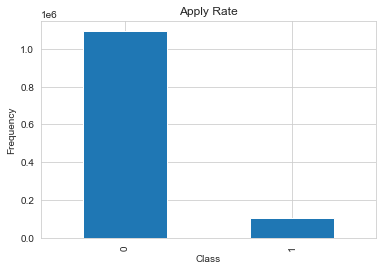

In [28]:
# Lets check the distribution for classes who applied and did not apply

count_classes = pd.value_counts(df['apply'], sort = True)
count_classes.plot(kind = 'bar')

plt.title("Apply Rate")
plt.xticks(range(2))
plt.xlabel("Class")
plt.ylabel("Frequency");

print('Number of customers who didnt apply:',df['apply'].value_counts()[0])
print('Number of customers who applied:',df['apply'].value_counts()[1])
print('Percentage of apply to non apply',df['apply'].value_counts()[0]/df['apply'].value_counts()[1],'%')

**Observation:**

The data is imbalanced and so we might have to use techniques like resampling (undersampling or oversampling) or use metrics like AUC-ROC curve or AUPRC or SMOTE to handle imbalanced data. Lets explore further which will help us decide what technique should we use. Note: It is already given in the dataset that I have to use AUC as the metric.

<AxesSubplot:>

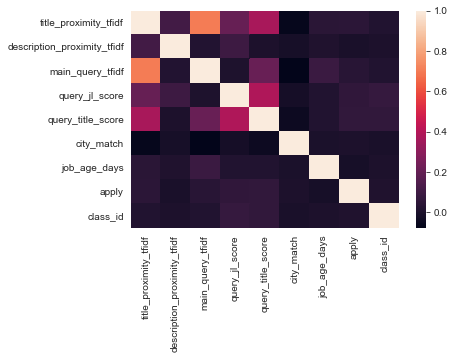

In [29]:
# Lets check the correlation between the features

sns.heatmap(df.corr())

**Observation:**

1. title_proximity_tfidf and main_query_tfidf are correlated with value of arounf 0.7
2. Other features are not highly correlated

<ipython-input-31-917cb0457d1b>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(number_of_rows + 1,number_of_columns,i+1)
C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
<ipython-input-31-917cb0457d1b>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(number_o

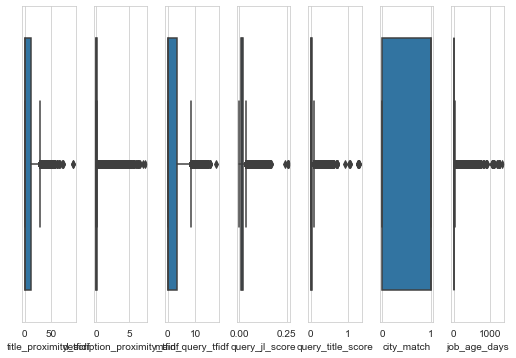

In [31]:
# Check the outliers

l = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match', 'job_age_days']
number_of_columns=7
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[l[i]], orient="v")
    plt.tight_layout()

**Observation:**

As we can see there are lot of outliers in the data

C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


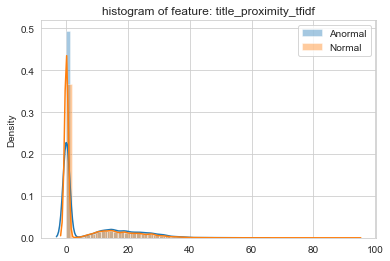

C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


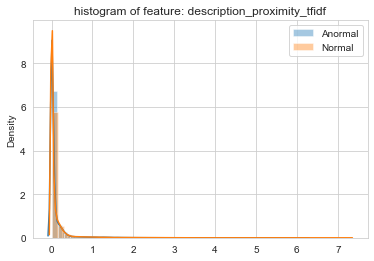

C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


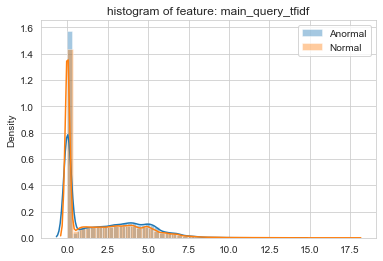

C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


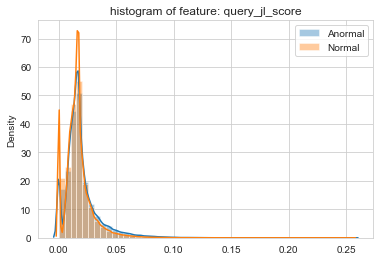

C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


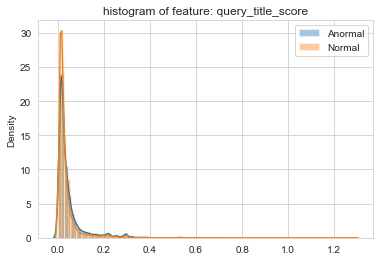

C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


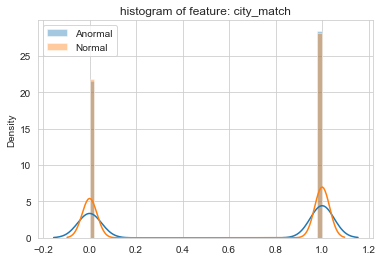

C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


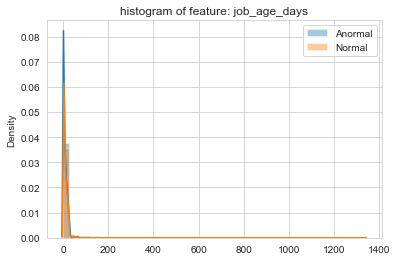

C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Formulatrix\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset h

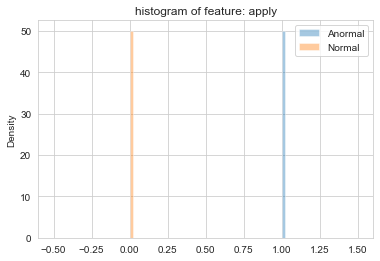

In [32]:
# Check the distribution

# Now to check the linearity of the variables it is a good practice to plot distribution graph and look for skewness 
# of features. Kernel density estimate (kde) is a quite useful tool for plotting the shape of a distribution.

for feature in df.columns[:-2]:
    ax = plt.subplot()
    sns.distplot(df[df['apply'] == 1][feature], bins=50, label='Anormal')
    sns.distplot(df[df['apply'] == 0][feature], bins=50, label='Normal')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(feature))
    plt.legend(loc='best')
    plt.show()

**Observation:**

For all the features, both apply and non apply rates have almost similar distributions

### Data Cleaning

In [33]:
# Firstly lets drop duplicate entries 

print(df.shape)
df = df.drop_duplicates(keep = 'first')
df.shape

(1200890, 10)


(1114759, 10)

In [34]:
# Check number of missing values in every columns
df.isnull().sum()

title_proximity_tfidf          212030
description_proximity_tfidf    212030
main_query_tfidf                    0
query_jl_score                      0
query_title_score                   0
city_match                     243469
job_age_days                        0
apply                               0
search_date_pacific                 0
class_id                            0
dtype: int64

In [35]:
# Lets check the value counts for the three columns
df['title_proximity_tfidf'].value_counts().head()

0.000000     612554
23.526310        14
8.866092         14
19.385944        14
33.553123        12
Name: title_proximity_tfidf, dtype: int64

In [36]:
df['description_proximity_tfidf'].value_counts().head()

0.000000    510731
1.814926         9
0.012474         8
0.716942         7
0.025261         6
Name: description_proximity_tfidf, dtype: int64

In [37]:
df['city_match'].value_counts().head()

1.0    486385
0.0    384905
Name: city_match, dtype: int64

**Observation:**

The first 2 columns contains mostly value zero so it would be a safe option to impute a value of '0' to the first two columns. For the 'city-match' column, lets check the percentage of apply and non apply before and after we remove the NaN values. If the percentage is same, we can conclude that it is safe to remove rows that have NaN values in City_match column.

In [38]:
df['title_proximity_tfidf'].fillna(0,inplace=True)
df['description_proximity_tfidf'].fillna(0,inplace=True)
df.dropna(subset=['city_match'],inplace=True)

Note: I will not be removing outliers since there is possibility of them carrying important information which can help us detect the apply and non apply cases

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871290 entries, 0 to 1200889
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title_proximity_tfidf        871290 non-null  float64
 1   description_proximity_tfidf  871290 non-null  float64
 2   main_query_tfidf             871290 non-null  float64
 3   query_jl_score               871290 non-null  float64
 4   query_title_score            871290 non-null  float64
 5   city_match                   871290 non-null  float64
 6   job_age_days                 871290 non-null  float64
 7   apply                        871290 non-null  int64  
 8   search_date_pacific          871290 non-null  object 
 9   class_id                     871290 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 73.1+ MB


In [40]:
# From the correlation graph, we observed that title_proximity_tfidf and main_query_tfidf are quite correlated, 
# lets merge them and get a single feature by multiplying both of them

df['main_title_tfidf'] = df['title_proximity_tfidf']*df['main_query_tfidf']

In [41]:
df = df.drop(['title_proximity_tfidf','main_query_tfidf'], axis=1)

In [42]:
df.head()

,description_proximity_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply,search_date_pacific,class_id,main_title_tfidf
0,0.000000,0.004824,0.006628,0.0,5.0,0,2018-01-21,-7613806991329176388,0.00000
1,0.043637,0.011935,0.011208,0.0,5.0,0,2018-01-21,-1361819269400927213,30.00666
2,0.043637,0.011935,0.011208,0.0,5.0,1,2018-01-21,-1361819269400927213,30.00666
3,0.000000,0.013046,0.033340,0.0,5.0,0,2018-01-23,-3623880078591607667,0.00000
4,0.000000,0.008065,0.008772,0.0,7.0,0,2018-01-24,-7054510112423797411,0.00000


In [43]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [44]:
len(df_train), len(df_val), len(df_test)

(522774, 174258, 174258)

In [46]:
y_train = df_train['apply'].values
y_val = df_val['apply'].values

In [47]:
del df_train['apply']
del df_val['apply']

In [48]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

NameError: name 'X_train' is not defined